In [1]:
import numpy as np
from scipy import sparse

import h2o
from h2o.automl import H2OAutoML
h2o.init(nthreads = -1,max_mem_size = "12G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /home/alex/miniconda3/envs/h20/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpw4inmdpq
  JVM stdout: /tmp/tmpw4inmdpq/h2o_alex_started_from_python.out
  JVM stderr: /tmp/tmpw4inmdpq/h2o_alex_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,00 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_alex_stbqzk
H2O cluster total nodes:,1
H2O cluster free memory:,12 Gb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"accepting new members, healthy"


In [2]:
X_train = sparse.load_npz("processed_data/raw_keyword_categorical_X_train_20k_feat.npz")
y_train = np.load("processed_data/raw_keyword_categorical_y_train.npy")
y_train = h2o.H2OFrame(y_train)
X_test = sparse.load_npz("processed_data/raw_keyword_categorical_test_processed_20k_feat.npz")

X_train = h2o.H2OFrame(X_train)
X_test = h2o.H2OFrame(X_test)

combined_train = X_train.cbind(y_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
y = "C110000"
x = combined_train.columns
x.remove(y)

# Run AutoML

In [4]:
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = combined_train)


AutoML progress: |████████████████████████████████████████████████████████| 100%


In [5]:
lb = aml.leaderboard

In [6]:
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20200221_092127,0.148802,0.385749,0.148802,0.310458,0.270718
StackedEnsemble_AllModels_AutoML_20200221_092127,0.148818,0.38577,0.148818,0.310552,0.270701
XGBoost_2_AutoML_20200221_092127,0.157919,0.39739,0.157919,0.337343,0.278494
GBM_4_AutoML_20200221_092127,0.16077,0.400961,0.16077,0.348566,0.281613
GBM_3_AutoML_20200221_092127,0.163293,0.404095,0.163293,0.35532,0.28386
XGBoost_1_AutoML_20200221_092127,0.164017,0.40499,0.164017,0.359857,0.284959
GLM_1_AutoML_20200221_092127,0.164835,0.405998,0.164835,0.352993,0.285862
GBM_2_AutoML_20200221_092127,0.165197,0.406444,0.165197,0.361149,0.285784
GBM_1_AutoML_20200221_092127,0.16637,0.407885,0.16637,0.36481,0.287607
XGBoost_3_AutoML_20200221_092127,0.171875,0.414578,0.171875,0.379498,0.292142


In [7]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])


In [8]:
metalearner.coef_norm()

{'Intercept': 0.42965979246026575,
 'XGBoost_2_AutoML_20200221_092127': 0.13980509143405623,
 'GBM_4_AutoML_20200221_092127': 0.036119599854358475,
 'GBM_3_AutoML_20200221_092127': 0.0,
 'XGBoost_1_AutoML_20200221_092127': 0.0034155997464314753,
 'GLM_1_AutoML_20200221_092127': 0.1381498848377734,
 'GBM_2_AutoML_20200221_092127': 0.0,
 'GBM_1_AutoML_20200221_092127': 0.011880218602186476,
 'XGBoost_3_AutoML_20200221_092127': 0.0,
 'DRF_1_AutoML_20200221_092127': 0.0,
 'GBM_5_AutoML_20200221_092127': 0.0}

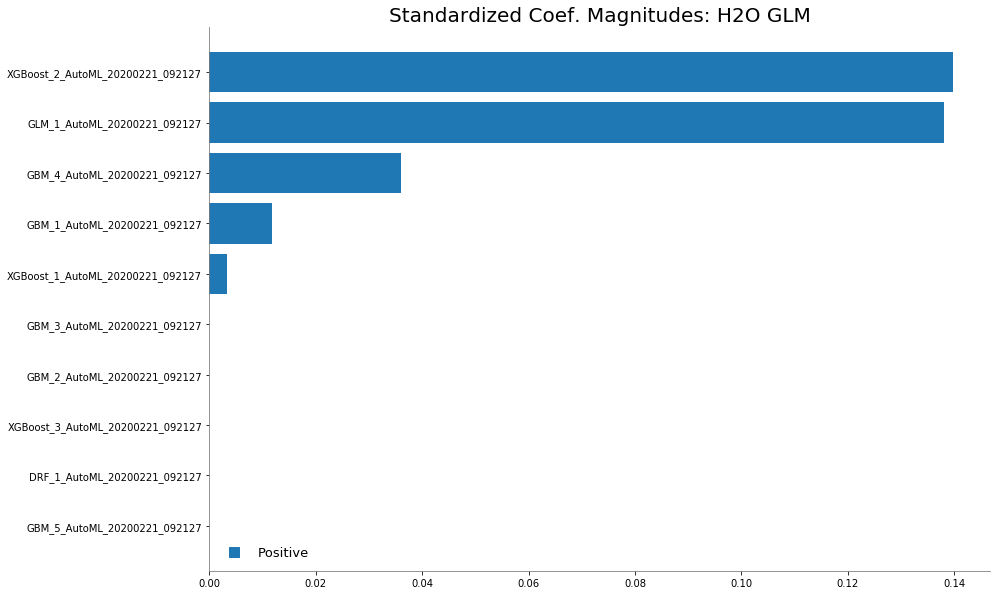

In [9]:
%matplotlib inline
metalearner.std_coef_plot()

In [10]:
h2o.save_model(aml.leader, path = "./saved_models/automl_001_bin")

'/home/alex/Documents/mlbase/disaster_tweet_kaggle/saved_models/automl_001_bin/StackedEnsemble_BestOfFamily_AutoML_20200221_092127'

In [11]:
# Shut down and release RAM
h2o.cluster().shutdown()

H2O session _sid_97a5 closed.
